# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



## Краткое введение от меня
Доброго времени суток! В этом ноутбуке мое решение домашки. Тут я кратко опишу идею которая собственно ниже реализована. Одна нейронка - написанная в исходном ноутбуке, я туду добавила два линейных слоя и батчнормы чтобы избежать переобучения. Потом я дообучила alexnet и vgg16 с заморозкой первых слоев и итеративным уменьшением градиентов (оно конечно не сильно используется так как эпох всего 15, но тем не менее переобучаться мешает). И в итоге прогнозы этих трех (всего лишь!) нейросеток я беру в среднем и получаю итоговый результат в 0.98405.

##Еще пара моментов
Иногда будут попадаться CtrlC-CtrlV с семинарских ноутбуков, надеюсь это не сильно помешает, вообще на мой взгляд должно быть читаемо
##И последний момент
акк на кагле: Полина_Дунаева
\
tg, если вдруг надо: @red_hoody

### Установка зависимостей

In [2]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# устанавливаем нужную версию wheel
!pip install wheel==0.34.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires wheel>=0.37.0, but you have wheel 0.34.1 which is incompatible.


In [4]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install -q torchvision
!pip3 install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
#считываем файлы с диска

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip -d simpsons_data

In [8]:
!ls simpsons_data

characters_illustration.png  sample_submission.csv  testset  train


In [9]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 27 13:34:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [11]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [13]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train':
          transform = transforms.Compose([
              transforms.ToTensor(),
              # добавим разворот для увеличения выборки
              transforms.RandomHorizontalFlip(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
        else:
          transform = transforms.Compose([
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
          ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [14]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [15]:
TRAIN_DIR = Path('simpsons_data/train')
TEST_DIR = Path('simpsons_data/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [16]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [17]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [18]:

# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

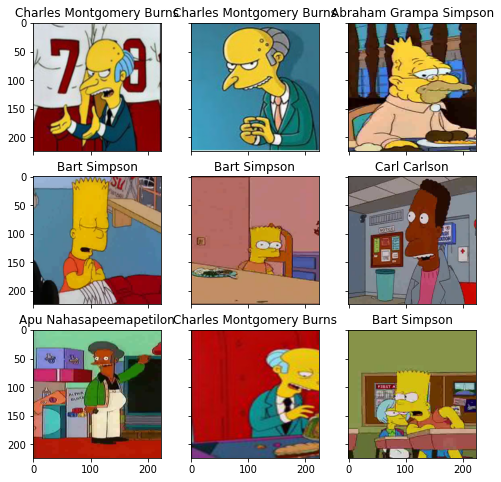

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [27]:
#первая модель
#добавлены батчнормы и два линейных слоя
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU(),
            nn.BatchNorm1d(96*5*5)
        )

        self.linear2 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 96 * 5 * 5),
            nn.ReLU()
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.linear2(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [23]:

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [28]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddi

Запустим обучение сети.

In [29]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [30]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=25, batch_size=80)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

loss 1.8606384695164755


epoch:   4%|▍         | 1/25 [03:16<1:18:25, 196.05s/it]


Epoch 001 train_loss: 1.8606     val_loss 1.3749 train_acc 0.5197 val_acc 0.6360
loss 0.9888278285791422


epoch:   8%|▊         | 2/25 [06:14<1:11:16, 185.93s/it]


Epoch 002 train_loss: 0.9888     val_loss 0.9810 train_acc 0.7239 val_acc 0.7392
loss 0.728254036578876


epoch:  12%|█▏        | 3/25 [08:51<1:03:17, 172.62s/it]


Epoch 003 train_loss: 0.7283     val_loss 0.9704 train_acc 0.7922 val_acc 0.7587
loss 0.5527402223489172


epoch:  16%|█▌        | 4/25 [11:22<57:23, 164.00s/it]


Epoch 004 train_loss: 0.5527     val_loss 0.8797 train_acc 0.8420 val_acc 0.7623
loss 0.4590417623246534


epoch:  20%|██        | 5/25 [13:52<52:58, 158.92s/it]


Epoch 005 train_loss: 0.4590     val_loss 0.7660 train_acc 0.8663 val_acc 0.8086
loss 0.3752213186162681


epoch:  24%|██▍       | 6/25 [16:30<50:13, 158.62s/it]


Epoch 006 train_loss: 0.3752     val_loss 0.7930 train_acc 0.8920 val_acc 0.8101
loss 0.30579084892987946


epoch:  28%|██▊       | 7/25 [19:01<46:51, 156.18s/it]


Epoch 007 train_loss: 0.3058     val_loss 0.8743 train_acc 0.9106 val_acc 0.8034
loss 0.2657910596195608


epoch:  32%|███▏      | 8/25 [21:31<43:43, 154.31s/it]


Epoch 008 train_loss: 0.2658     val_loss 0.8901 train_acc 0.9251 val_acc 0.8156
loss 0.22469105371279097


epoch:  36%|███▌      | 9/25 [24:02<40:50, 153.13s/it]


Epoch 009 train_loss: 0.2247     val_loss 0.7824 train_acc 0.9345 val_acc 0.8389
loss 0.2194704152568933


epoch:  40%|████      | 10/25 [26:51<39:28, 157.90s/it]


Epoch 010 train_loss: 0.2195     val_loss 0.8558 train_acc 0.9376 val_acc 0.8271
loss 0.18530256408089643


epoch:  44%|████▍     | 11/25 [29:23<36:27, 156.23s/it]


Epoch 011 train_loss: 0.1853     val_loss 0.8093 train_acc 0.9491 val_acc 0.8103
loss 0.17705779306576794


epoch:  48%|████▊     | 12/25 [31:54<33:29, 154.56s/it]


Epoch 012 train_loss: 0.1771     val_loss 0.8761 train_acc 0.9510 val_acc 0.8426
loss 0.16534564567926666


epoch:  52%|█████▏    | 13/25 [34:22<30:33, 152.79s/it]


Epoch 013 train_loss: 0.1653     val_loss 0.8943 train_acc 0.9529 val_acc 0.8357
loss 0.16497424117595771


epoch:  56%|█████▌    | 14/25 [36:52<27:51, 151.96s/it]


Epoch 014 train_loss: 0.1650     val_loss 0.9157 train_acc 0.9549 val_acc 0.8223
loss 0.151006026994488


epoch:  60%|██████    | 15/25 [39:24<25:19, 151.90s/it]


Epoch 015 train_loss: 0.1510     val_loss 1.0321 train_acc 0.9594 val_acc 0.8319
loss 0.15935319585827584


epoch:  64%|██████▍   | 16/25 [41:53<22:38, 150.94s/it]


Epoch 016 train_loss: 0.1594     val_loss 0.8958 train_acc 0.9596 val_acc 0.8269
loss 0.12864091219699067


epoch:  68%|██████▊   | 17/25 [44:20<19:59, 149.89s/it]


Epoch 017 train_loss: 0.1286     val_loss 1.2162 train_acc 0.9659 val_acc 0.8229
loss 0.1262457729884679


epoch:  72%|███████▏  | 18/25 [46:47<17:21, 148.80s/it]


Epoch 018 train_loss: 0.1262     val_loss 0.9483 train_acc 0.9675 val_acc 0.8449
loss 0.12448719422285424


epoch:  76%|███████▌  | 19/25 [49:17<14:55, 149.31s/it]


Epoch 019 train_loss: 0.1245     val_loss 1.1030 train_acc 0.9687 val_acc 0.8410
loss 0.12164245013650539


epoch:  80%|████████  | 20/25 [51:48<12:28, 149.67s/it]


Epoch 020 train_loss: 0.1216     val_loss 1.2724 train_acc 0.9689 val_acc 0.8330
loss 0.1451972616397196


epoch:  84%|████████▍ | 21/25 [54:17<09:58, 149.67s/it]


Epoch 021 train_loss: 0.1452     val_loss 1.2209 train_acc 0.9639 val_acc 0.8363
loss 0.13079398320418906


epoch:  88%|████████▊ | 22/25 [57:04<07:44, 154.79s/it]


Epoch 022 train_loss: 0.1308     val_loss 1.0983 train_acc 0.9670 val_acc 0.8426
loss 0.1272237901290813


epoch:  92%|█████████▏| 23/25 [59:37<05:08, 154.31s/it]


Epoch 023 train_loss: 0.1272     val_loss 0.9253 train_acc 0.9685 val_acc 0.8393
loss 0.10862580414109987


epoch:  96%|█████████▌| 24/25 [1:02:09<02:33, 153.43s/it]


Epoch 024 train_loss: 0.1086     val_loss 1.0401 train_acc 0.9718 val_acc 0.8412
loss 0.10861223251482054


epoch: 100%|██████████| 25/25 [1:04:40<00:00, 155.22s/it]


Epoch 025 train_loss: 0.1086     val_loss 1.2008 train_acc 0.9737 val_acc 0.8462


In [ ]:
#ну собсна получилось не очень, что то в районе 83-84%
#печально конечно но для начала не так уж плохо

Построим кривые обучения

In [31]:
loss, acc, val_loss, val_acc = zip(*history)

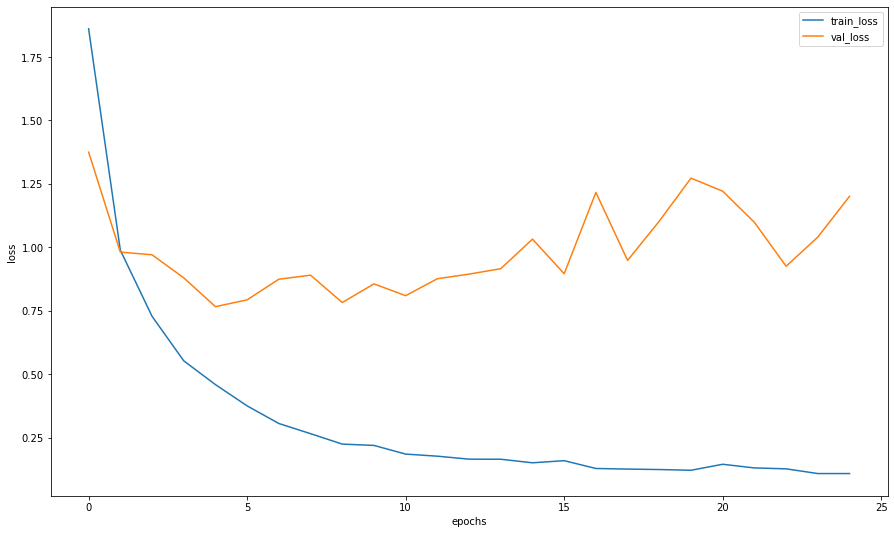

In [32]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [33]:
# теперь попробуем transfer learning 
# обучим Alexnet, vgg16 с заморозкой слоев и уменьшением градиента
# еще обучим resnet50 с заменой классификатора
# потом ответы от всех сеток и возьмем среднее
# получим в итоге хорошее предсказание наверное

In [34]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [35]:
#вторая модель
AlexnetFrozen = models.alexnet(pretrained=True)
AlexnetFrozen

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in AlexnetFrozen.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
AlexnetFrozen.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if train_on_gpu:
    AlexnetFrozen = AlexnetFrozen.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(AlexnetFrozen.features.parameters())[-layers_to_unfreeze:] + 
                      list(AlexnetFrozen.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [37]:
AlexnetFrozen

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [38]:
history = train(train_dataset, val_dataset, model=AlexnetFrozen, epochs=15, batch_size=80)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.2194111103221514

Epoch 001 train_loss: 1.2194     val_loss 0.6618 train_acc 0.6876 val_acc 0.8240
loss 0.45003357652274123

Epoch 002 train_loss: 0.4500     val_loss 0.5214 train_acc 0.8821 val_acc 0.8645
loss 0.2525649175901661

Epoch 003 train_loss: 0.2526     val_loss 0.4998 train_acc 0.9306 val_acc 0.8815
loss 0.17593658247209065

Epoch 004 train_loss: 0.1759     val_loss 0.4648 train_acc 0.9513 val_acc 0.8882
loss 0.134947778005586

Epoch 005 train_loss: 0.1349     val_loss 0.5241 train_acc 0.9625 val_acc 0.8917
loss 0.13407957407689958

Epoch 006 train_loss: 0.1341     val_loss 0.5966 train_acc 0.9639 val_acc 0.8961
loss 0.10560353698454647

Epoch 007 train_loss: 0.1056     val_loss 0.5667 train_acc 0.9716 val_acc 0.9024
loss 0.10586889116937692

Epoch 008 train_loss: 0.1059     val_loss 0.6483 train_acc 0.9694 val_acc 0.8980
loss 0.10497741972048835

Epoch 009 train_loss: 0.1050     val_loss 0.8256 train_acc 0.9703 val_acc 0.8791
loss 0.12510408621125482

Epoch 010 train

In [39]:
#ну вот уже лучше, уже примерно 88-89%

In [44]:
loss, acc, val_loss, val_acc = zip(*history)

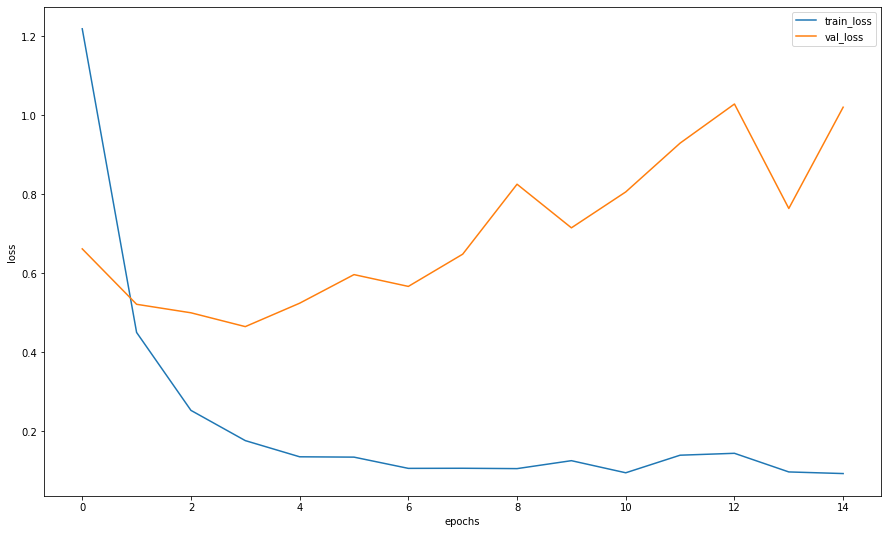

In [45]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [46]:
#третья модель
VGGFrozen = models.vgg16(pretrained=True)
VGGFrozen

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in VGGFrozen.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
VGGFrozen.classifier = nn.Linear(num_features, 42)

# Использовать ли GPU
if train_on_gpu:
    VGGFrozen = VGGFrozen.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(VGGFrozen.features.parameters())[-layers_to_unfreeze:] + 
                      list(VGGFrozen.classifier.parameters()), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [48]:
VGGFrozen

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
history = train(train_dataset, val_dataset, model=VGGFrozen, epochs=15, batch_size=80)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 1.481774481070012

Epoch 001 train_loss: 1.4818     val_loss 0.8575 train_acc 0.6211 val_acc 0.7810
loss 0.5922480995802828

Epoch 002 train_loss: 0.5922     val_loss 0.5956 train_acc 0.8437 val_acc 0.8393
loss 0.3817858421823023

Epoch 003 train_loss: 0.3818     val_loss 0.5472 train_acc 0.8958 val_acc 0.8640
loss 0.26887626751912796

Epoch 004 train_loss: 0.2689     val_loss 0.5916 train_acc 0.9276 val_acc 0.8603
loss 0.1928580802286861

Epoch 005 train_loss: 0.1929     val_loss 0.6325 train_acc 0.9469 val_acc 0.8642
loss 0.1752559211677226

Epoch 006 train_loss: 0.1753     val_loss 0.6038 train_acc 0.9518 val_acc 0.8857
loss 0.1509029921707822

Epoch 007 train_loss: 0.1509     val_loss 0.6848 train_acc 0.9585 val_acc 0.8754
loss 0.12481650983576233

Epoch 008 train_loss: 0.1248     val_loss 0.7880 train_acc 0.9636 val_acc 0.8695
loss 0.1250596772783258

Epoch 009 train_loss: 0.1251     val_loss 0.7257 train_acc 0.9677 val_acc 0.8773
loss 0.10429023588800576

Epoch 010 train_los

In [51]:
#здесь получается примерно 86-87% что тоже неплохо

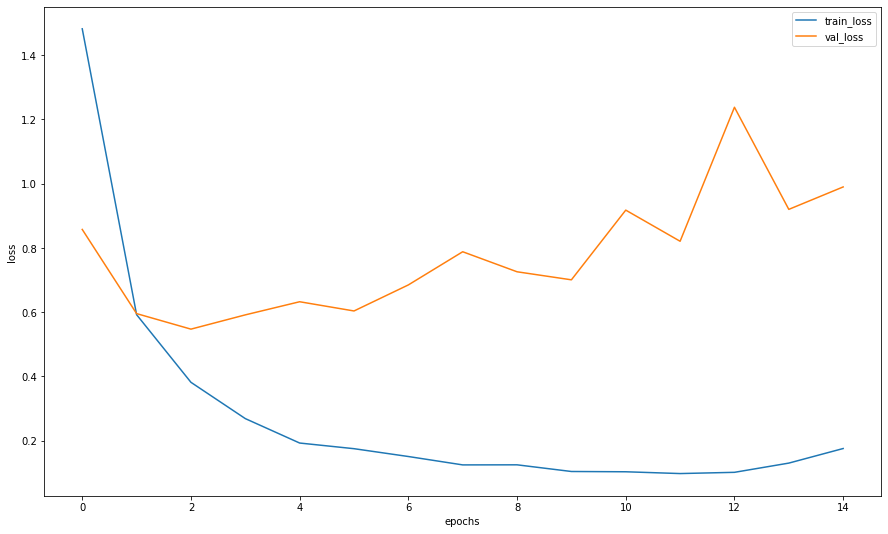

In [52]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [53]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [54]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs1 = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))
probs2 = predict_one_sample(AlexnetFrozen, ex_img.unsqueeze(0))
probs3 = predict_one_sample(VGGFrozen, ex_img.unsqueeze(0))

probs_im = (probs1 + probs2 + probs3) / 3

In [55]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs1 = predict(simple_cnn, imgs)
probs2 = predict(AlexnetFrozen, imgs)
probs3 = predict(VGGFrozen, imgs)

probs_ims = (probs1 + probs2 + probs3) / 3

In [56]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [57]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [58]:
len(label_encoder.classes_)

42

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [59]:
actual_labels

[4, 0, 4, 4, 4, 5, 0, 6, 0, 4, 0, 0, 6, 6, 4, 6, 6, 0, 0, 6]

In [60]:
y_pred

array([4, 0, 4, 4, 4, 5, 0, 6, 0, 4, 0, 0, 6, 6, 4, 6, 6, 0, 0, 6])

In [61]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)


array([1., 1., 1., 1.])

In [ ]:
#очень приятный примерчик выдал везде 1

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

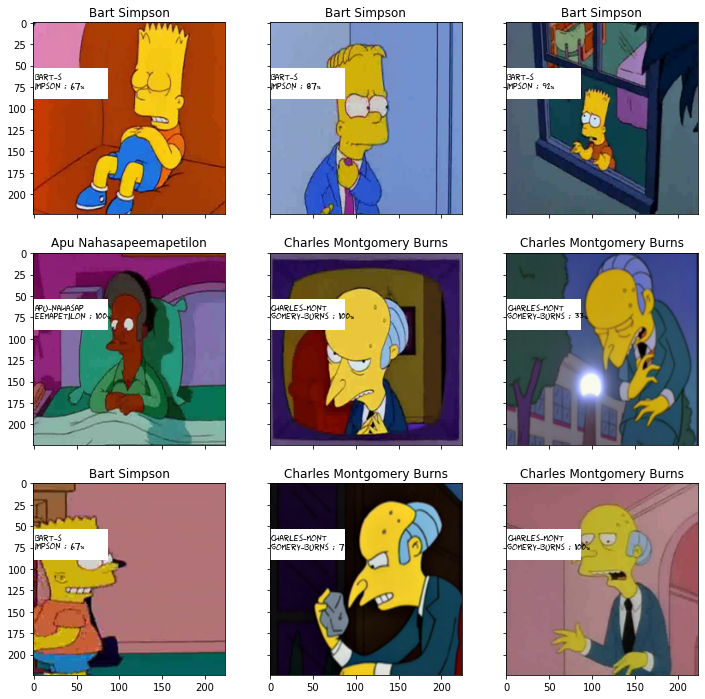

In [63]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred1 = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    prob_pred2 = predict_one_sample(AlexnetFrozen, im_val.unsqueeze(0))
    prob_pred3 = predict_one_sample(VGGFrozen, im_val.unsqueeze(0))
    prob_pred = (prob_pred1 + prob_pred2 + prob_pred3) / 3
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
#в итоге каждая нейронка угадывает около 85% но вместе они делают аж все 98%

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [64]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs1 = predict(simple_cnn, test_loader)
probs2 = predict(AlexnetFrozen, test_loader)
probs3 = predict(VGGFrozen, test_loader)

probs = (probs1 + probs2 + probs3) / 3

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [65]:
! ls 

gdrive	label_encoder.pkl  sample_data	simpsons_data


In [66]:
import pandas as pd
my_submit = pd.read_csv("simpsons_data/sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [67]:
my_submit.to_csv('gdrive/My Drive/simple_cnn_baseline.csv', index=False)

# Итоговый скор на кагле: 0.98405